<a href="https://colab.research.google.com/github/12tilak34/Fintechstartup/blob/main/%F0%9D%90%92%F0%9D%90%9E%F0%9D%90%9A%F0%9D%90%AC%F0%9D%90%A8%F0%9D%90%A7%F0%9D%90%9A%F0%9D%90%A5_%F0%9D%90%87%F0%9D%90%B2%F0%9D%90%9B%F0%9D%90%AB%F0%9D%90%A2%F0%9D%90%9D_%F0%9D%90%90%F0%9D%90%AE%F0%9D%90%9A%F0%9D%90%A7%F0%9D%90%AD_%F0%9D%90%92%F0%9D%90%AD%F0%9D%90%AB%F0%9D%90%9A%F0%9D%90%AD%F0%9D%90%9E%F0%9D%90%A0%F0%9D%90%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **𝐒𝐞𝐚𝐬𝐨𝐧𝐚𝐥 𝐇𝐲𝐛𝐫𝐢𝐝 𝐐𝐮𝐚𝐧𝐭 𝐒𝐭𝐫𝐚𝐭𝐞𝐠𝐲**

In [ ]:
pip install gnews

In [ ]:
pip install yfinance

In [15]:
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from gnews import GNews

# Fetch data of indian stocks from yahoo finance
symbols = ['RITES', 'RELIANCE', 'TATAMOTORS', 'TAJGVK']

data = {}
for symbol in symbols:
    data[symbol] = yf.download(symbol + '.NS', start='2020-01-01', end='2024-01-01')

# Initialize GNews
gnews = GNews()

# Function to fetch and process news for a symbol
def fetch_and_process_news(symbol):
    news = gnews.get_news(symbol)
    news_df = pd.DataFrame(news)
    news_df['symbol'] = symbol
    news_df['date'] = pd.to_datetime(news_df['published date'], format='%a, %d %b %Y %H:%M:%S GMT')
    return news_df

# Fetch news data
news_data = pd.concat([fetch_and_process_news(symbol) for symbol in symbols])

# Display first 5 rows
print(news_data.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


                                               title  \
0  Winston Manning Military Rites | Obituaries | ...   
1  Private Rites by Julia Armfield review – famil...   
2  Spotlight Album: Kosmic Attunement to the Male...   
3  Robinson-Patman Deserves Last Rites, Not Resur...   
4  Rites of Spring music festival is April 20 - V...   

                                         description  \
0  Winston Manning Military Rites | Obituaries | ...   
1  Private Rites by Julia Armfield review – famil...   
2  Spotlight Album: Kosmic Attunement to the Male...   
3  Robinson-Patman Deserves Last Rites, Not Resur...   
4  Rites of Spring music festival is April 20  Va...   

                  published date  \
0  Sun, 02 Jun 2024 05:00:00 GMT   
1  Sun, 02 Jun 2024 12:00:00 GMT   
2  Thu, 30 May 2024 17:00:12 GMT   
3  Wed, 29 May 2024 10:16:23 GMT   
4  Thu, 18 Apr 2024 07:00:00 GMT   

                                                 url  \
0  https://news.google.com/rss/articles/CBMieGh0d... 

In [17]:
# Download the VADER lexicon
!pip install nltk
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer # Import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Apply sentiment analysis
news_data['Sentiment'] = news_data['description'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Aggregate daily sentiment scores
news_data.set_index('date', inplace=True)
daily_sentiment = news_data.groupby(['symbol', news_data.index.date])['Sentiment'].mean().unstack(level=0)

# Display the first few rows of the aggregated sentiment dataset
print(daily_sentiment.head())

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


symbol      RELIANCE  RITES  TAJGVK  TATAMOTORS
2001-08-08       NaN    NaN  0.0000         NaN
2014-05-12       NaN    NaN  0.5106         NaN
2015-11-04       NaN    NaN  0.0000         NaN
2016-01-05       NaN    NaN  0.0000         NaN
2016-01-30       NaN    NaN  0.0000         NaN


In [18]:
# Function to add technical indicators and merge sentiment data
def add_features(data, symbol):
    df = data[symbol].copy()
    df['MA50'] = df['Close'].rolling(window=50).mean()
    df['MA200'] = df['Close'].rolling(window=200).mean()
    df['Volatility'] = df['Close'].rolling(window=50).std()
    df['Sentiment'] = daily_sentiment[symbol]
    df['Sentiment'] = df['Sentiment'].fillna(0)
    df['Return'] = df['Close'].pct_change()
    df['Future Return'] = df['Close'].shift(-1) / df['Close'] - 1
    df['Target'] = (df['Future Return'] > 0).astype(int)
    return df.dropna()

# Add features to all datasets
feature_data = {symbol: add_features(data, symbol) for symbol in symbols}

# Combine feature data into a single DataFrame
combined_features = pd.concat([feature_data[symbol] for symbol in symbols])

# Split data into training and testing sets
X = combined_features[['MA50', 'MA200', 'Volatility', 'Sentiment', 'Return']]
y = combined_features['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train a Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Validate the model
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Validation Accuracy: {accuracy:.2f}')

Validation Accuracy: 0.51


<ipython-input-20-3fdf70721560>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_features['Signal'][combined_features['Prediction'] == 1] = 1


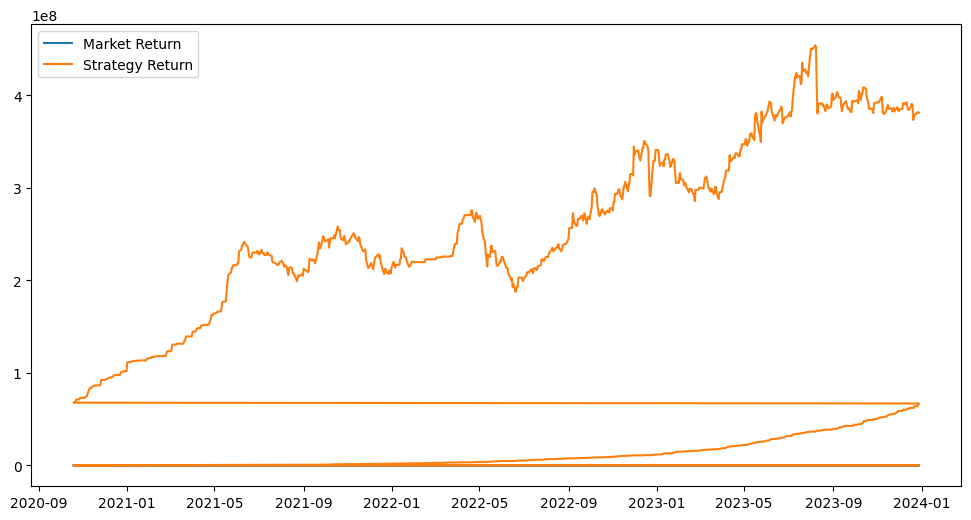

Total Market Return: 27.68
Total Strategy Return: 380976913.46


In [20]:
import matplotlib.pyplot as plt
# Generate trading signals
combined_features['Prediction'] = model.predict(X)

# Buy signal: when the model predicts the price will go up
combined_features['Signal'] = 0
combined_features['Signal'][combined_features['Prediction'] == 1] = 1

# Calculate strategy returns
combined_features['Strategy Return'] = combined_features['Signal'].shift(1) * combined_features['Return']

# Plot cumulative returns
combined_features['Cumulative Market Return'] = (1 + combined_features['Return']).cumprod()
combined_features['Cumulative Strategy Return'] = (1 + combined_features['Strategy Return']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(combined_features['Cumulative Market Return'], label='Market Return')
plt.plot(combined_features['Cumulative Strategy Return'], label='Strategy Return')
plt.legend()
plt.show()

# Calculate and print performance metrics
total_market_return = combined_features['Cumulative Market Return'].iloc[-1] - 1
total_strategy_return = combined_features['Cumulative Strategy Return'].iloc[-1] - 1
print(f'Total Market Return: {total_market_return:.2f}')
print(f'Total Strategy Return: {total_strategy_return:.2f}')